In [89]:
import albumentations
import albumentations.pytorch
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.pyplot import figure
from skimage import io, color

import config
from tsp import warp_image_cv

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Content:
* Test RGB2Lab and Lab2RGB
  * OpenCV version
  * RGB from Lab
  * Skimage version
* TSP Example
* Dataset image transform
* Merge L and ab in torch

# Test RGB2Lab and Lab2RGB 
## OpenCV version:

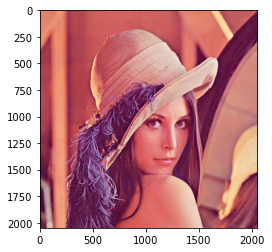

In [63]:
lenna = cv2.imread('Lenna.png')
_ = plt.imshow(lenna[...,::-1])

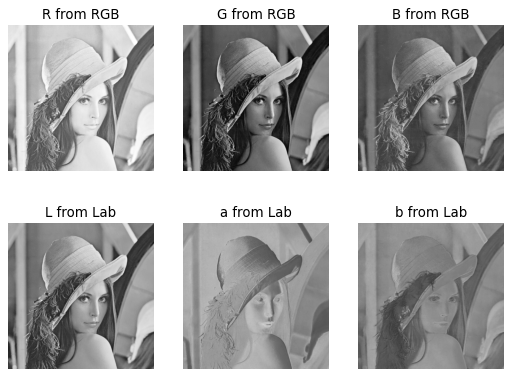

In [64]:
figure(figsize=(8, 6), dpi=80)

plt.subplot(2, 3, 1)
plt.axis('off')
plt.imshow(lenna[..., 2], cmap='gray')
plt.title('R from RGB')

plt.subplot(2, 3, 2)
plt.axis('off')
plt.imshow(lenna[..., 1], cmap='gray')
plt.title('G from RGB')

plt.subplot(2, 3, 3)
plt.axis('off')
plt.imshow(lenna[..., 0], cmap='gray')
_ = plt.title('B from RGB')

lab_lenna = cv2.cvtColor(lenna, cv2.COLOR_BGR2LAB)

plt.subplot(2, 3, 4)
plt.axis('off')
plt.imshow(lab_lenna[..., 0], cmap='gray')
plt.title('L from Lab')

plt.subplot(2, 3, 5)
plt.axis('off')
plt.imshow(lab_lenna[..., 1], cmap='gray')
plt.title('a from Lab')

plt.subplot(2, 3, 6)
plt.axis('off')
plt.imshow(lab_lenna[..., 2], cmap='gray')
_ = plt.title('b from Lab')


In [65]:
%timeit lab_lenna = cv2.cvtColor(lenna, cv2.COLOR_BGR2LAB)

4.91 ms ± 307 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### RGB from LAB

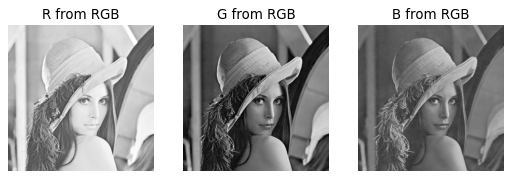

In [75]:
rbg_from_lab_lenna = cv2.cvtColor(lab_lenna, cv2.COLOR_LAB2BGR)
figure(figsize=(8, 6), dpi=80)

plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(rbg_from_lab_lenna[..., 2], cmap='gray')
plt.title('R from RGB')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(rbg_from_lab_lenna[..., 1], cmap='gray')
plt.title('G from RGB')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(rbg_from_lab_lenna[..., 0], cmap='gray')
_ = plt.title('B from RGB')

## Skimage version:

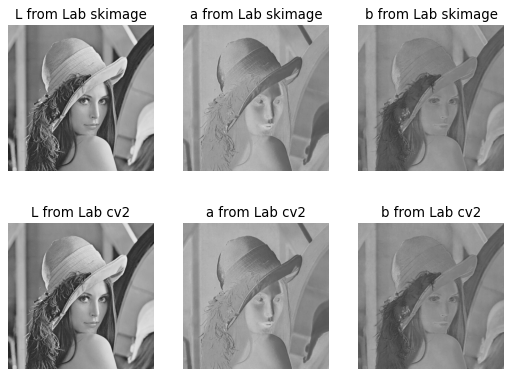

In [66]:
rgb = io.imread('Lenna.png')
lab = color.rgb2lab(rgb)
    
    
figure(figsize=(8, 6), dpi=80)

plt.subplot(2, 3, 1)
plt.axis('off')
plt.imshow(lab[..., 0], cmap='gray')
plt.title('L from Lab skimage')

plt.subplot(2, 3, 2)
plt.axis('off')
plt.imshow(lab[..., 1], cmap='gray')
plt.title('a from Lab skimage')

plt.subplot(2, 3, 3)
plt.axis('off')
plt.imshow(lab[..., 2], cmap='gray')
_ = plt.title('b from Lab skimage')

plt.subplot(2, 3, 4)
plt.axis('off')
plt.imshow(lab_lenna[..., 0], cmap='gray')
plt.title('L from Lab cv2')

plt.subplot(2, 3, 5)
plt.axis('off')
plt.imshow(lab_lenna[..., 1], cmap='gray')
plt.title('a from Lab cv2')

plt.subplot(2, 3, 6)
plt.axis('off')
plt.imshow(lab_lenna[..., 2], cmap='gray')
_ = plt.title('b from Lab cv2')


In [67]:
%timeit _ = color.rgb2lab(rgb)

1.89 s ± 49.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Conclusion: skimage is much worse than opencv

# TSP Example

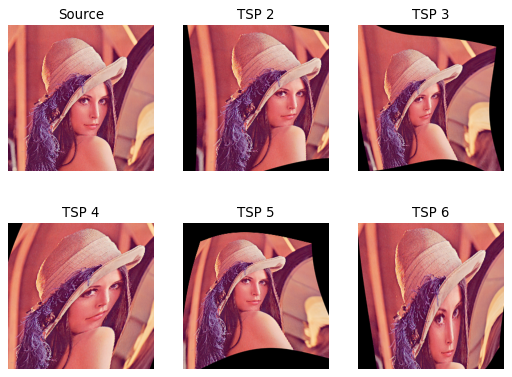

In [71]:
lenna = cv2.imread('Lenna.png')
lenna = cv2.resize(lenna, (256, 256))


figure(figsize=(8, 6), dpi=80)

plt.subplot(2, 3, 1)
plt.axis('off')
plt.imshow(lenna[...,::-1])
plt.title('Source')
for i in range(2, 7):
    im = warp_image_cv(lenna)
    plt.subplot(2, 3, i)
    plt.axis('off')
    plt.imshow(im[...,::-1])
    plt.title(f'TSP {i}')

In [73]:
%timeit warp_image_cv(lenna)

179 ms ± 19.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Dataset image transform

torch.Size([1, 2, 256, 256])


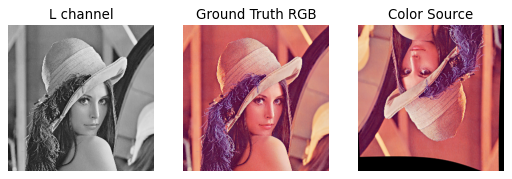

In [131]:
def process_image(image_path):
    lenna = cv2.imread(image_path)
    ground_truth_rgb = cv2.resize(lenna, (config.IMAGE_SIZE, config.IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
    lab = cv2.cvtColor(ground_truth_rgb, cv2.COLOR_BGR2LAB)
    tsp = warp_image_cv(ground_truth_rgb)

    transform_color_source_aug = albumentations.Compose(
        [
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.GaussNoise(var_limit=0.5),
        ]
    )

    transform_torch = albumentations.Compose(
        [
            albumentations.ToFloat(),
            albumentations.pytorch.ToTensorV2(),
        ]
    )

    color_source = transform_color_source_aug(image=tsp)['image']
    color_source = transform_torch(image=color_source)['image']
    lab = transform_torch(image=lab)['image']
    ground_truth_rgb = transform_torch(image=ground_truth_rgb)['image'] 
    return lab, ground_truth_rgb, color_source

lab, ground_truth_rgb, color_source = process_image('Lenna.png')

figure(figsize=(8, 6), dpi=80)

plt.subplot(1, 3, 1)
plt.axis('off')
print(lab[0,...].unsqueeze(0).shape)
numpy_image = lab.numpy()
numpy_image = np.transpose(numpy_image, (1,2,0))
plt.imshow(numpy_image[...,0], cmap='gray')
plt.title('L channel')

plt.subplot(1, 3, 2)
plt.axis('off')
numpy_image = ground_truth_rgb.numpy()
numpy_image = np.transpose(numpy_image, (1,2,0))
plt.imshow(numpy_image[...,::-1])
plt.title('Ground Truth RGB')

plt.subplot(1, 3, 3)
plt.axis('off')
numpy_image = color_source.numpy()
numpy_image = np.transpose(numpy_image, (1,2,0))
plt.imshow(numpy_image[...,::-1])
_ = plt.title('Color Source')

In [124]:
%timeit process_image('Lenna.png')

346 ms ± 39.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Merge L and ab in torch

In [141]:
lab = torch.randn(3,3,212,121)
ab = lab[:, 1:, ...]
l_channel = lab[:, 0, ...].unsqueeze(1)
print(lab.shape, ab.shape, l_channel.shape)
merged_lab = torch.cat((l_channel, ab), 1)
print(merged_lab.shape)
print(merged_lab[0, 0, 0, 0], merged_lab[0, 1, 0, 0], merged_lab[0, 2, 0, 0])
print(l_channel[0, 0, 0, 0], ab[0, 0, 0, 0], ab[0, 1, 0, 0])

torch.Size([3, 3, 212, 121]) torch.Size([3, 2, 212, 121]) torch.Size([3, 1, 212, 121])
torch.Size([3, 3, 212, 121])
tensor(-0.3068) tensor(-0.4265) tensor(-0.2327)
tensor(-0.3068) tensor(-0.4265) tensor(-0.2327)
